# Model Comparison: when do differences matter?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn import cluster
from sklearn import svm
from sklearn import tree
# import the whole model selection module
from sklearn import model_selection
sns.set_theme(palette='colorblind')

# load data, 20% test
iris_X, iris_y = datasets.load_iris(return_X_y=True)
iris_X_train, iris_X_test, iris_y_train, iris_y_test = model_selection.train_test_split(
  iris_X,iris_y, test_size =.2)


# setup DT & params
dt = tree.DecisionTreeClassifier()

params_dt = {'criterion':['gini','entropy'],
       'max_depth':[2,3,4,5,6],
    'min_samples_leaf':list(range(2,20,2))}

dt_opt = model_selection.GridSearchCV(dt,params_dt)


# optmize DT
dt_opt.fit(iris_X_train,iris_y_train)

# store DT results in dataframe
dt_df = pd.DataFrame(dt_opt.cv_results_)


# setup svm and params
svm_clf = svm.SVC()
param_grid = {'kernel':['linear','rbf'], 'C':[.5, .75,1,2,5,7, 10]}
svm_opt = model_selection.GridSearchCV(svm_clf,param_grid)

# optmize and save svm results
svm_opt.fit(iris_X_train,iris_y_train)
sv_df = pd.DataFrame(svm_opt.cv_results_)

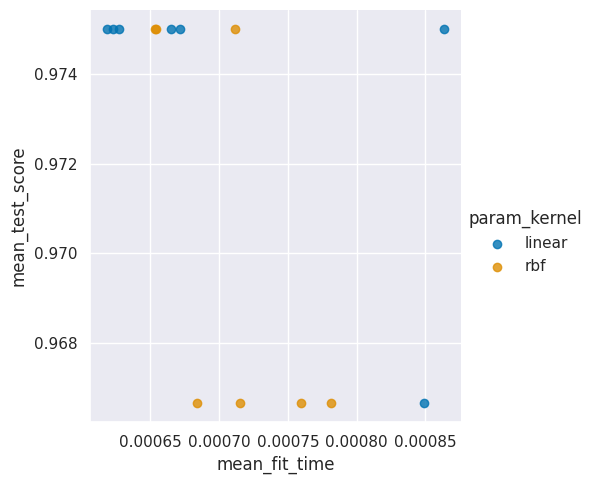

In [2]:
description_vars = ['param_C', 'param_kernel', 'params',]
vars_to_plot = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']
svm_time = sv_df.melt(id_vars= description_vars,
           value_vars=vars_to_plot)
sns.lmplot(data=sv_df, x='mean_fit_time',y='mean_test_score',
     hue='param_kernel',fit_reg=False)

In [3]:
len(iris_X_train)/5

24.0

In [4]:
23/24

0.9583333333333334

In [5]:
svm_opt.predict_proba

AttributeError: predict_proba is not available when  probability=False

In [6]:
def classification_confint(acc, n):
    '''
    Compute the 95% confidence interval for a classification problem.
    acc -- classification accuracy
    n -- number of observations used to compute the accuracy
    Returns a tuple (lb,ub)
    '''
    interval = 1.96*np.sqrt(acc*(1-acc)/n)
    lb = max(0, acc - interval)
    ub = min(1.0, acc + interval)
    return (lb,ub)

In [7]:
type(dt_opt)

sklearn.model_selection._search.GridSearchCV

In [8]:
dt_opt.best_score_, svm_opt.best_score_

(0.95, 0.975)

In [9]:
classification_confint(dt_opt.best_score_, len(iris_X_train))

(0.9110047011380431, 0.9889952988619568)

In [10]:
classification_confint(dt_opt.best_score_, len(iris_X_train)*10)

(0.9376686037557244, 0.9623313962442755)